In [47]:
# main import
import sys
import os
import json
import nltk
import numpy as np
import pandas as pd

# analytics import
sys.path.append('..')
from preprocess import MediumBlogPost

# utils import
from utils import parse_date, get_word_count

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error

# visualization imports
import seaborn.apionly as sns
import matplotlib.pyplot as plt
%matplotlib inline


files = ['data-science.jl', 'startup.jl']

## load data

In [2]:
dfs = []
for file_name in files:
    file_path = os.path.join(os.environ['RAW_DATA_PATH'], file_name)
    with open(file_path) as f:
        for line in f:
            # get raw data
            row = MediumBlogPost(**json.loads(line)).to_frame()
            dfs.append(row)

df = pd.concat(dfs).reset_index(drop=True)

In [3]:
df.head(5)

,title,publish_time,author,url,author_url,headings,contents,mins_read,claps,lang,tags
0,The Woman Behind the Data – Data Wonderment – ...,2018-01-01,Data Wonderment,https://medium.com/@datawonderment/the-woman-b...,https://medium.com/@datawonderment,The Woman Behind the Data,"October 2, 2017 By Ashley Albers Often we see ...",2,0,en,"[Data, Datascience, Orlando]"
1,CoreML — Building the model for Boston Prices ...,2018-01-01,Dr J Rogel-Salazar,https://medium.com/@quantum_tunnel/coreml-buil...,https://medium.com/@quantum_tunnel,CoreML — Building the model for Boston Prices ...,In the last post we have taken a look at the ...,3,1,en,"[Coreml, Data Science, iOS, Machine Learning, ..."
2,TRANSFER LEARNING DEMYSTIFIED – Najeeb Khan – ...,2018-01-01,Najeeb Khan,https://medium.com/@najeebnik21/transfer-learn...,https://medium.com/@najeebnik21,Let us understand transfer learning concept fr...,TRANSFER LEARNING DEMYSTIFIED What is Transfer...,4,1,en,"[Machine Learning, Data Science, Artificial In..."
3,Autonomous Data as a Beginner – Data Autonomy ...,2018-01-01,Kevin Kautz,https://medium.com/data-autonomy/autonomous-da...,https://medium.com/@kevin642,Autonomous Data as a Beginner,Professor Peter J. Denning published an articl...,2,0,en,"[Artificial Intelligence, Data, Analytics, Dat..."
4,How Timing Can Affect Your New Years Resolutio...,2018-01-01,Matthew Amsden,https://medium.com/proofpilot/can-timing-can-a...,https://medium.com/@matthewamsden,How Timing Can Affect Your New Years Resolutio...,"As the calendar turns to a new year, as is tra...",3,0,en,"[Health, Wellness, Research, Data Science, New..."


## feature engineering

Base on previous EDA, we think the following features are sensible for predicting claps
1. year, month, day
2. title word count, stop word count, unusual word count
3. headings word count, stop word count, unusual word count
4. contents sentence count, contents word count, stop word count, unusual word count
5. number of buzz words in contents (optional / require n-gram tokens)
6. author number of blogs, average claps, min claps, max claps

NOTE:
1. feature eng items 1 to 5 are agnostic to future data
2. feature eng item 6 would potentially lead to data leakage if not handle properly, we should use hashing technique

### part i

In [14]:
# # 1. get date
# df_date = parse_date(df.publish_time)
# # 2. title wc
# df_title_wc = get_word_count(df.title)
# # 3. headings wc
# df_headings_wc = get_word_count(df.headings)
# # 4. contents wc
# df_contents_wc = get_word_count(df.contents)

In [3]:
# # save data
# df_features = pd.concat(
#     [
#         df_date,
#         df_title_wc,
#         df_headings_wc,
#         df_contents_wc,
#         df.author,
#         df.mins_read,
#     ],
#     axis=1
# )
# df_features.to_pickle('../data/features_V1.pkl')

In [35]:
df_features = pd.read_pickle('../data/features_V10.pkl')

In [36]:
df_features.head()

,year,month,day,title_word_count,title_stopword_count,title_unusual_word_count,title_total_word_count,headings_word_count,headings_stopword_count,headings_unusual_word_count,headings_total_word_count,contents_word_count,contents_stopword_count,contents_unusual_word_count,contents_total_word_count,author,mins_read
0,2018,1,1,6,2,2,10,3,2,0,5,174,269,127,570,Data Wonderment,2
1,2018,1,1,5,2,7,14,4,2,4,10,152,191,95,438,Dr J Rogel-Salazar,3
2,2018,1,1,4,0,4,8,21,7,6,34,324,338,152,814,Najeeb Khan,4
3,2018,1,1,6,2,2,10,3,2,0,5,126,224,93,443,Kevin Kautz,2
4,2018,1,1,4,5,5,14,4,5,5,14,306,357,242,905,Matthew Amsden,3


## train / test split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    df_features,
    df.claps,
    test_size=0.2,
    random_state=99)

print(X_train.shape, X_test.shape)

(20016, 17) (5005, 17)


### part ii

In [12]:
# hash author to create author features
X_train['author'] = X_train['author'].apply(lambda name: hash(name) // 10 ** 9)


# add blogs count
blogs_cnt = pd.DataFrame(
    X_train['author'].groupby(X_train['author']).count()
).rename(columns={'author': 'blogs_cnt'})

# target encoding
claps_agg = pd.DataFrame(y_train.groupby(X_train['author']).agg(['mean', 'median', 'max', 'min']))
claps_agg = claps_agg.rename(columns={agg_name: 'author_{}'.format(agg_name) for agg_name in claps_agg.columns})

# merge on author
X_train = pd.DataFrame(
    pd.concat(
        [
            X_train.reset_index(drop=True), 
            blogs_cnt.reindex(X_train.author).reset_index(drop=True),
            claps_agg.reindex(X_train.author).reset_index(drop=True)
        ],
        axis=1
    ),
).drop('author', axis=1)

# hash author to create in test data
X_test['author'] = X_test['author'].apply(lambda name: hash(name) // 10 ** 9)
X_test = pd.DataFrame(
    pd.concat(
        [
            X_test.reset_index(drop=True), 
            blogs_cnt.loc[X_test.author].reset_index(drop=True),
            claps_agg.loc[X_test.author].reset_index(drop=True)
        ],
        axis=1
    ),
).drop('author', axis=1).fillna(0)

X_train.head(5)

/Users/Kevin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Kevin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Kevin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/in

,year,month,day,title_word_count,title_stopword_count,title_unusual_word_count,title_total_word_count,headings_word_count,headings_stopword_count,headings_unusual_word_count,...,contents_word_count,contents_stopword_count,contents_unusual_word_count,contents_total_word_count,mins_read,blogs_cnt,author_mean,author_median,author_max,author_min
0,2018,6,18,5,5,4,14,8,5,4,...,513,657,662,1832,6,1,0.000000,0.0,0,0
1,2018,1,15,8,2,2,12,8,2,2,...,660,853,526,2039,10,2,0.000000,0.0,0,0
2,2018,7,12,2,1,6,9,4,3,6,...,261,285,234,780,4,11,19.545455,1.0,103,0
3,2018,4,26,6,2,6,14,3,2,3,...,274,392,197,863,3,1,15.000000,15.0,15,15
4,2018,6,1,6,5,3,14,13,12,7,...,370,527,301,1198,6,1,6.000000,6.0,6,6


## some inspection

In [47]:
blogs_cnt.describe()

,blogs_cnt
count,20016.000000
mean,4.327238
std,8.344232
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,80.000000


In [46]:
claps_agg.describe()

,author_mean,author_median,author_max,author_min
count,20016.000000,20016.000000,20016.000000,20016.000000
mean,133.294864,111.278827,373.459782,70.290418
std,1042.736334,926.797538,3097.161407,778.728193
min,0.000000,0.000000,0.000000,0.000000
25%,0.500000,0.000000,1.000000,0.000000
50%,9.000000,5.000000,15.000000,1.000000
75%,61.000000,53.000000,99.000000,29.000000
max,67000.000000,67000.000000,103000.000000,67000.000000


## correlation signals
1. we like to see if there is any linear correlation in features
2. might potentially need to do log transform claps

In [42]:
# correlation measure
data = pd.concat([X_train, y_train.reset_index(drop=True)], axis=1).corr()
pd.DataFrame(data['claps'].sort_values(ascending=False))

,claps
claps,1.000000
author_mean,0.826848
author_median,0.810123
author_min,0.708459
author_max,0.623714
contents_stopword_count,0.108917
contents_total_word_count,0.103576
mins_read,0.103105
contents_word_count,0.101546
contents_unusual_word_count,0.087514


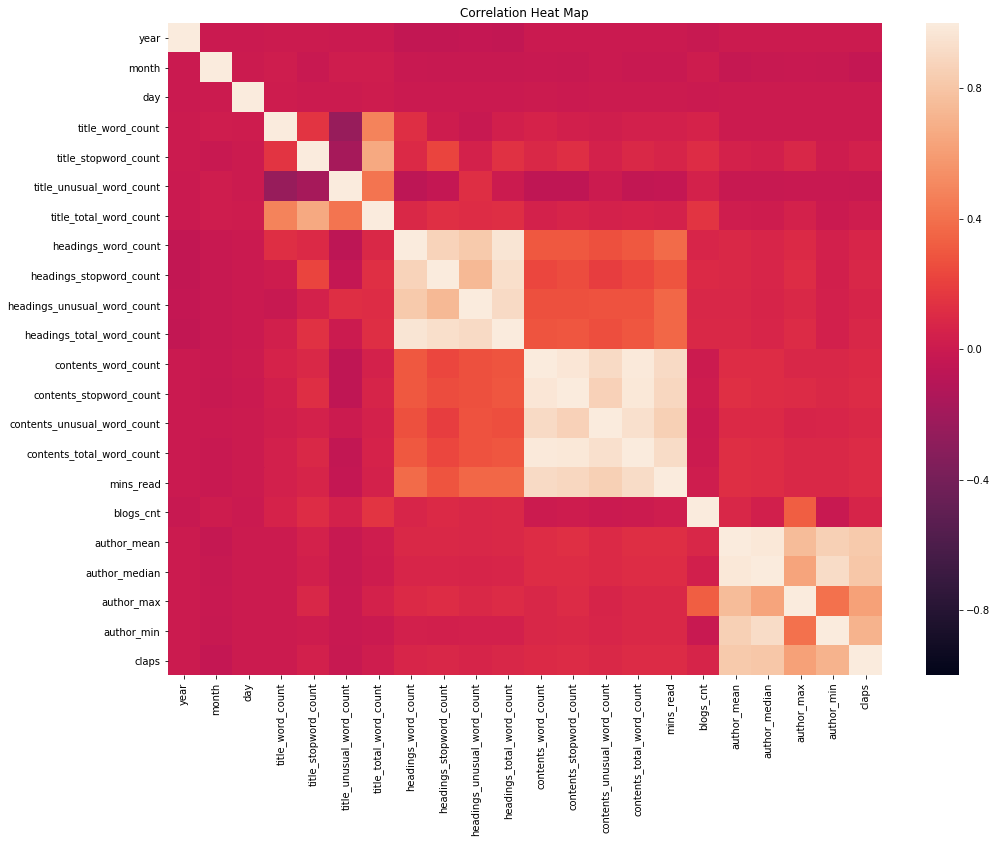

In [43]:
# heat map visual
fig, ax = plt.subplots(figsize=(16, 12))
ax.set_title('Correlation Heat Map')
sns.heatmap(data ,vmin=-1, vmax=1, ax=ax)

## Modeling Road Map
Above analysis shows strong linear relationship between claps and other features, so we will start with linear models.<br/> 
Below are the models we can try:

1. Ridge
2. Lasso (check weights to confirm intuition)
3. Random Forest

In [44]:
# 1. Ridge
ridge_pipe = Pipeline(
    [
        ('t0', StandardScaler()),
        ('e0', RidgeCV(
            alphas=[1.0, 2.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 50.0],
            scoring='neg_mean_squared_error',
            cv=None,
            store_cv_values=True))
    ]
).fit(X_train, y_train)


# 2. Lasso
lasso_pipe = Pipeline(
    [
        ('t0', StandardScaler()),
        ('e0', LassoCV(
            n_alphas=100,
            cv=None,
            random_state=99))
    ]
).fit(X_train, y_train)


# 3. random forest
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=3,
    random_state=99
).fit(X_train, y_train)


## features analysis

After model done trainning, we can inspect feature importances to see which features drive model's prediction

We found following concerns:
1. All three models think "claps avg by author" is the most important features
2. Lasso model makes prediction based on only one feature "claps avg by author"
3. We need to add more features: unique word count, word vectors, topics

In [45]:
pd.DataFrame(
    {
        'features': X_train.columns.values,
        'corr_w_claps': data['claps'].loc[X_train.columns].values.round(3),
        'ridge_weights': ridge_pipe.steps[-1][-1].coef_.round(3),
        'lasso_weights': lasso_pipe.steps[-1][-1].coef_.round(3),
        'rf_feature_importances': rf.feature_importances_.round(3)
    }
)

,features,corr_w_claps,ridge_weights,lasso_weights,rf_feature_importances
0,year,0.001,0.170,0.000,0.000
1,month,-0.033,-16.082,-0.000,0.011
2,day,0.002,-2.648,-0.000,0.030
3,title_word_count,0.004,0.723,-0.000,0.002
4,title_stopword_count,0.043,2.310,0.000,0.009
5,title_unusual_word_count,-0.022,-5.022,-0.000,0.021
6,title_total_word_count,0.017,-1.358,-0.000,0.019
7,headings_word_count,0.077,-19.237,0.000,0.009
8,headings_stopword_count,0.080,15.823,0.000,0.005
9,headings_unusual_word_count,0.070,7.245,0.000,0.029


## scoring
We use mean squared error and root mean squared error for model performance measure

In [48]:
# prediction
ridge_pred = ridge_pipe.predict(X_test).clip(0, )
lasso_pred = lasso_pipe.predict(X_test).clip(0, )
rf_pred = rf.predict(X_test)


# rmse score
ridge_mse = (mean_squared_error(y_test, ridge_pred)).round(2)
lasso_mse = (mean_squared_error(y_test, lasso_pred)).round(2)
rf_mse = (mean_squared_error(y_test, rf_pred)).round(2)

# rmse score
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_pred)).round(2)
lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_pred)).round(2)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred)).round(2)

In [49]:
pd.DataFrame(
    {
        'ridge': [ridge_rmse, ridge_mse],
        'lasso': [ridge_rmse, lasso_mse],
        'rf': [rf_rmse, rf_mse],
    },
    index=['rmse', 'mse']
)

,ridge,lasso,rf
rmse,663.37,663.37,732.88
mse,440055.95,423926.81,537112.01
